# Handling Missing Values

The objective of this project is to evaluate the impact of different missing-data handling techniques on the performance of machine learning models using the [Pima Indians Diabetes](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database) dataset with missing values. By applying strategies such as row deletion, mean/median imputation, KNN imputation, and MICE, the study compares how each approach affects model accuracy and reliability—measured via F1-Score and ROC AUC—to determine the most effective method given the data’s missingness patterns.

<img src="https://i.imgur.com/68u0dD2.png" width="800" >



## Import Libraries

In [4]:
# Data wrangling
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Missing values charts
import missingno as msno

# Stats
from scipy.stats import ks_2samp

# Pre
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import classification_report, f1_score, roc_auc_score

# Models
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Imputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge


## Data Exploration

In [6]:
df = pd.read_csv("./Dataset/Diabetes Missing Data.csv")

In [7]:
df.head()

,Pregnant,Glucose,Diastolic_BP,Skin_Fold,Serum_Insulin,BMI,Diabetes_Pedigree,Age,Class
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [8]:
df.shape

(768, 9)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Pregnant           768 non-null    int64  
 1   Glucose            763 non-null    float64
 2   Diastolic_BP       733 non-null    float64
 3   Skin_Fold          541 non-null    float64
 4   Serum_Insulin      394 non-null    float64
 5   BMI                757 non-null    float64
 6   Diabetes_Pedigree  768 non-null    float64
 7   Age                768 non-null    int64  
 8   Class              768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


A preliminary inspection reveals missing values in several key features. Specifically, `Glucose`, `Diastolic_BP`, `Skin_Fold`, `Serum_Insulin`, and `BMI` contain null values, with `Serum_Insulin` and `Skin_Fold` exhibiting the most significant data loss (374 and 227 missing entries, respectively). These missing values may impact the reliability of any predictive model trained on this data, especially considering that these features are biologically relevant for diabetes prediction.

In [11]:
df.describe()

,Pregnant,Glucose,Diastolic_BP,Skin_Fold,Serum_Insulin,BMI,Diabetes_Pedigree,Age,Class
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


The high standard deviation in variables like `Serum_Insulin` and `Skin_Fold` suggests substantial variability.

In [13]:
df.isna().sum() / len(df) * 100 # Percentaje of Missing Values

Pregnant              0.000000
Glucose               0.651042
Diastolic_BP          4.557292
Skin_Fold            29.557292
Serum_Insulin        48.697917
BMI                   1.432292
Diabetes_Pedigree     0.000000
Age                   0.000000
Class                 0.000000
dtype: float64

The percentage of missing values confirms that missingness is a substantial issue in the dataset. This level of missingness may significantly influence the effectiveness of machine learning models and demands careful treatment. 

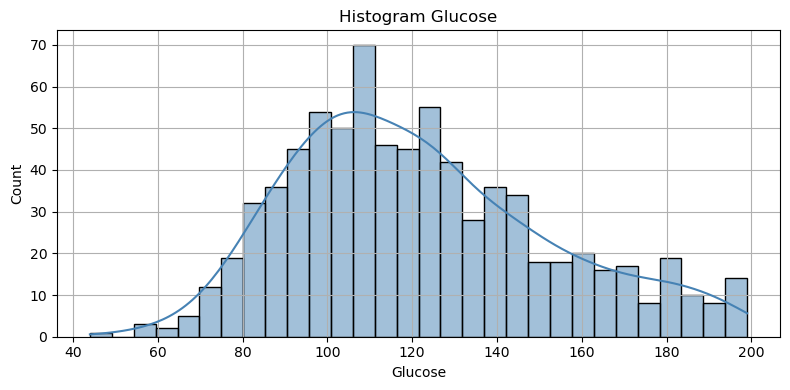

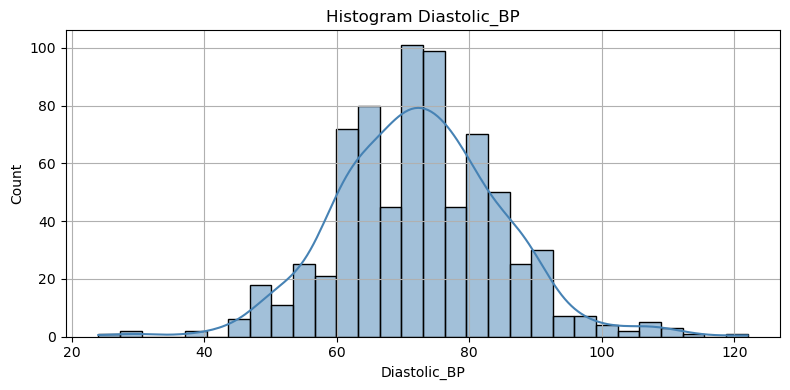

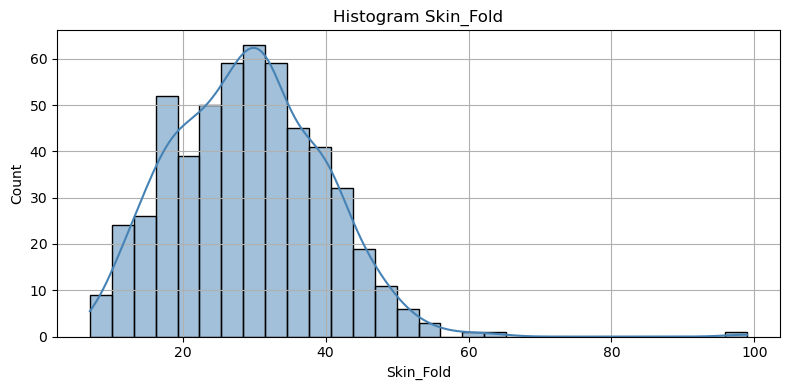

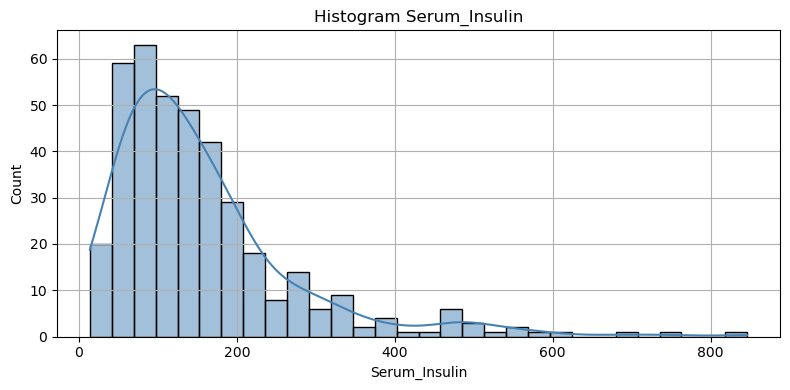

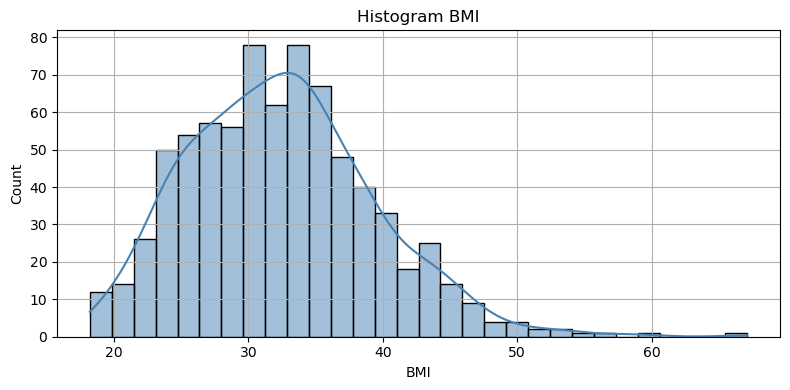

In [15]:
# Distributions of Columns with Missing Values

for column in df.columns:
    if df[column].isna().sum() > 0:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[column].dropna(), kde=True, bins=30, color='steelblue')
        plt.title(f'Histogram {column}')
        plt.xlabel(column)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

The histograms reveal distinct distribution patterns across the variables with missing data, which has important implications for selecting appropriate imputation strategies. `Glucose` and `BMI` exhibit right-skewed distributions, with most values concentrated around the mid-ranges and long tails extending toward higher values. `Diastolic_BP` appears roughly normally distributed, suggesting that simple imputations like mean or median could be suitable here. `Skin_Fold` and `Serum_Insulin`, however, are highly right-skewed with substantial variability, indicating that imputing missing values using the mean may lead to biased results.

### Missing Values Exploration

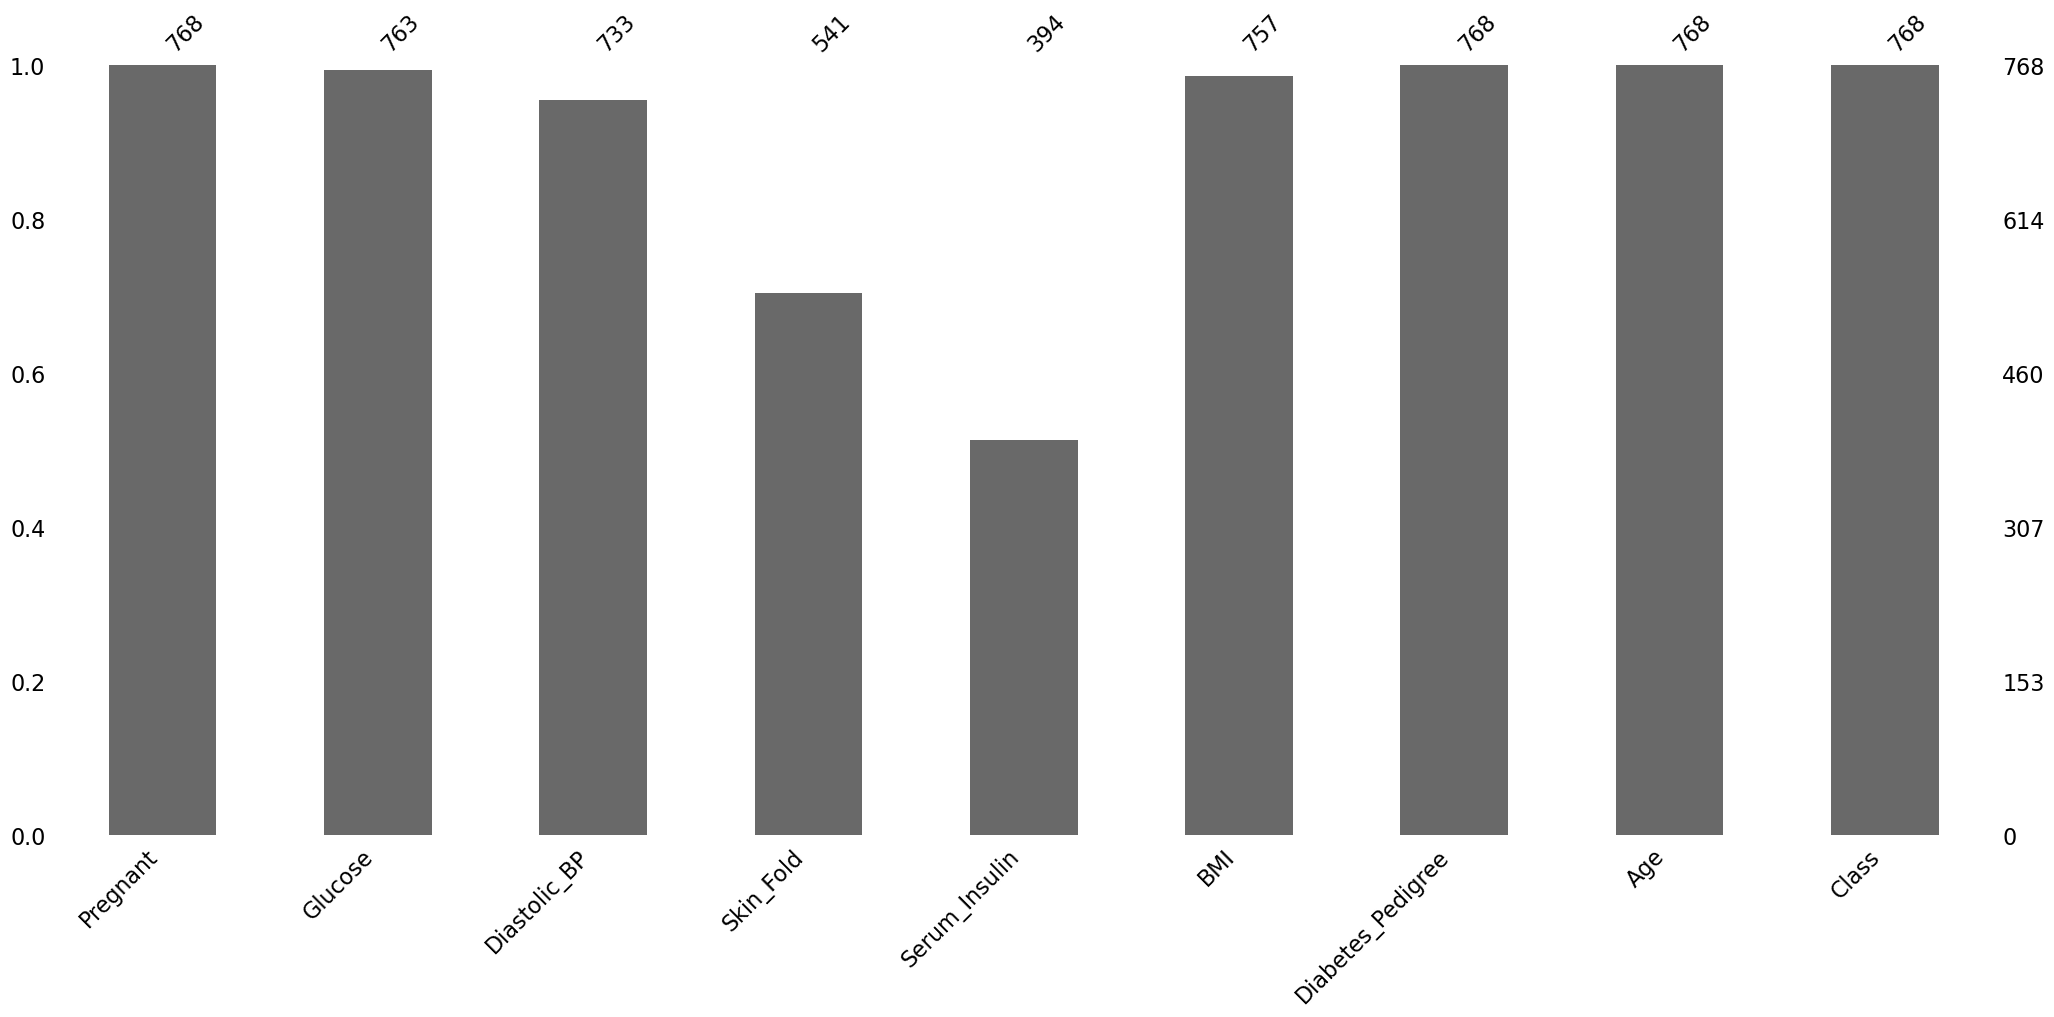

In [18]:
msno.bar(df)
plt.show()

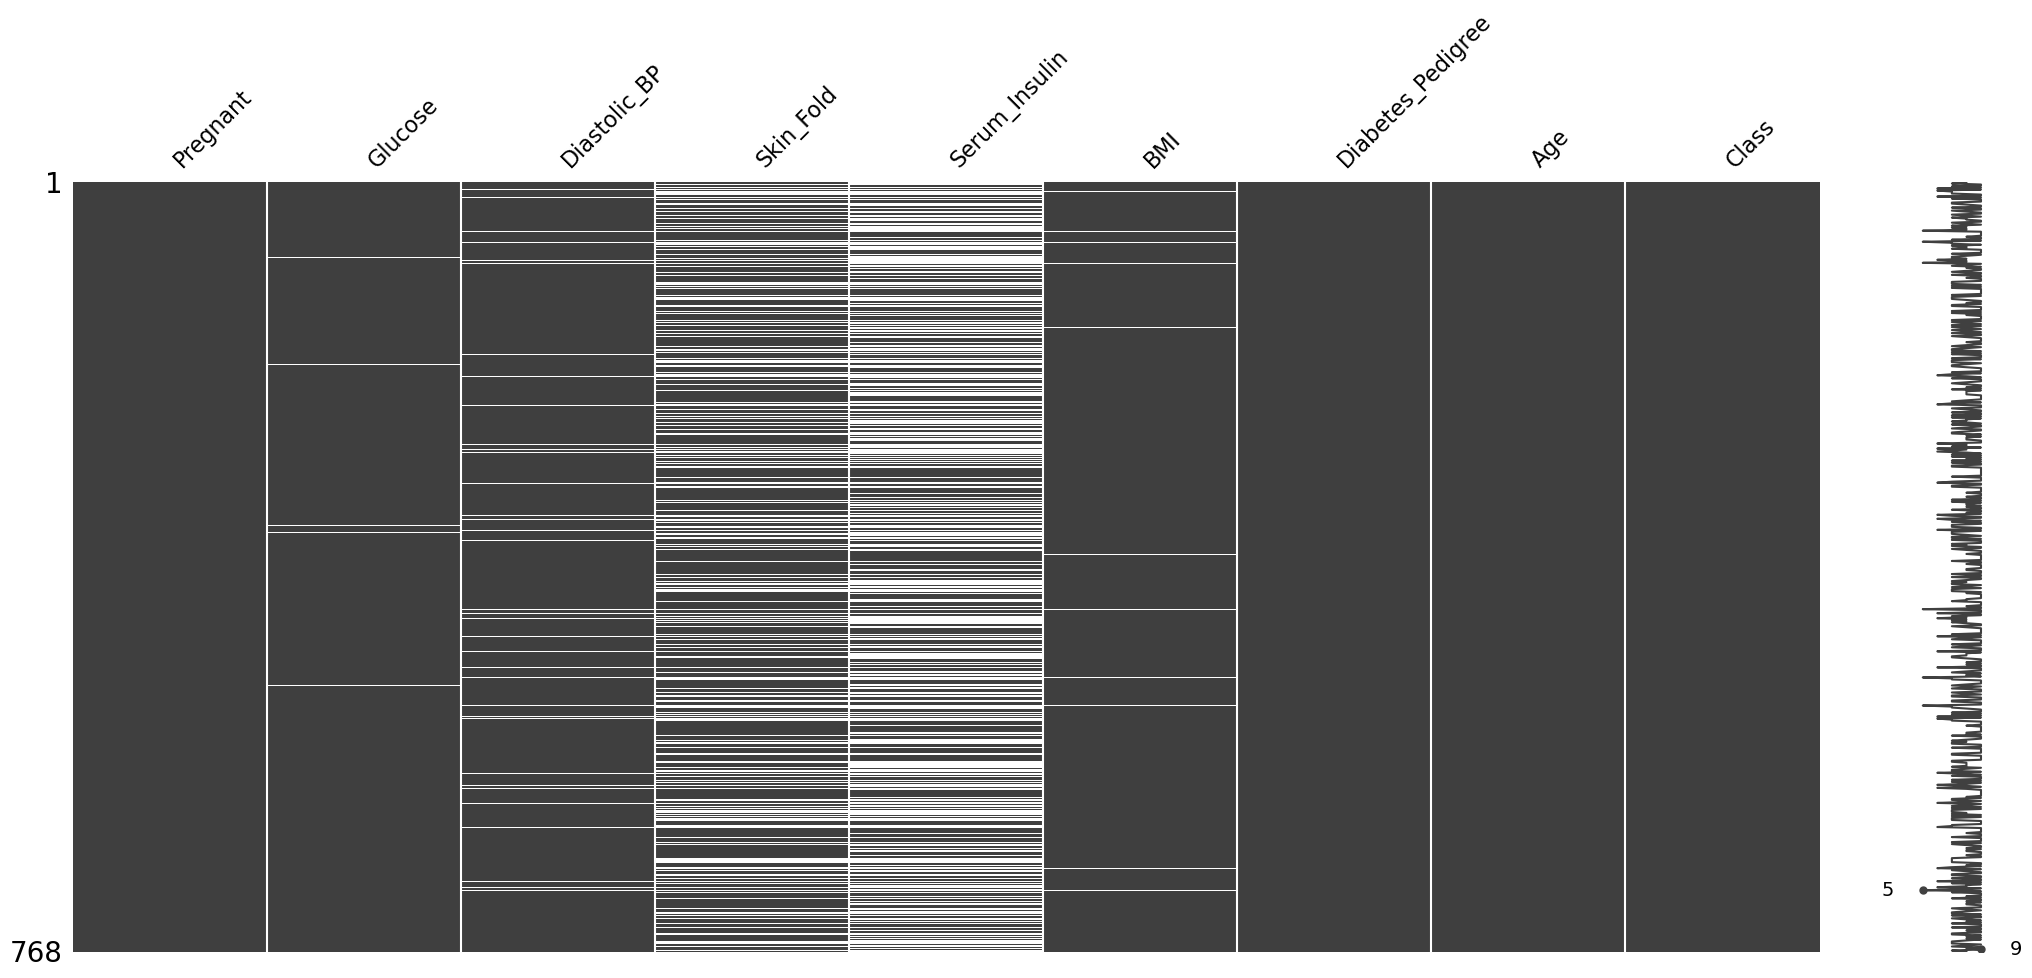

In [19]:
msno.matrix(df) 
plt.show()

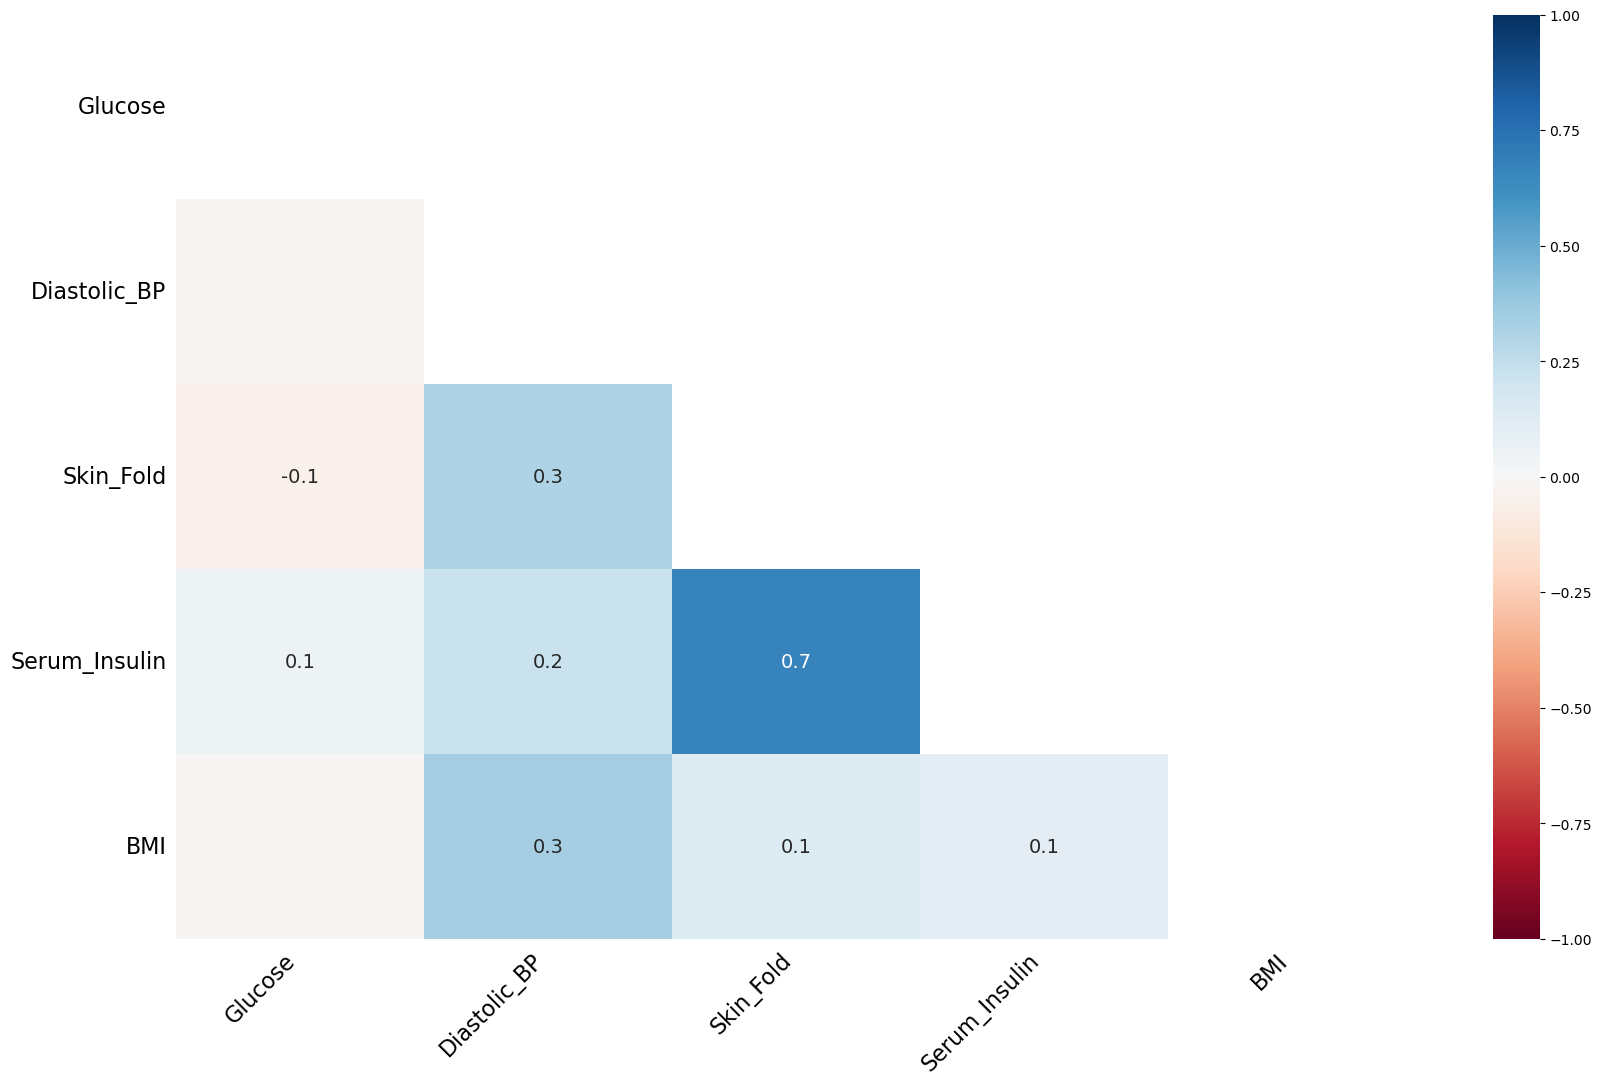

In [20]:
msno.heatmap(df)
plt.show()

serum_insulin and skin_fold are related

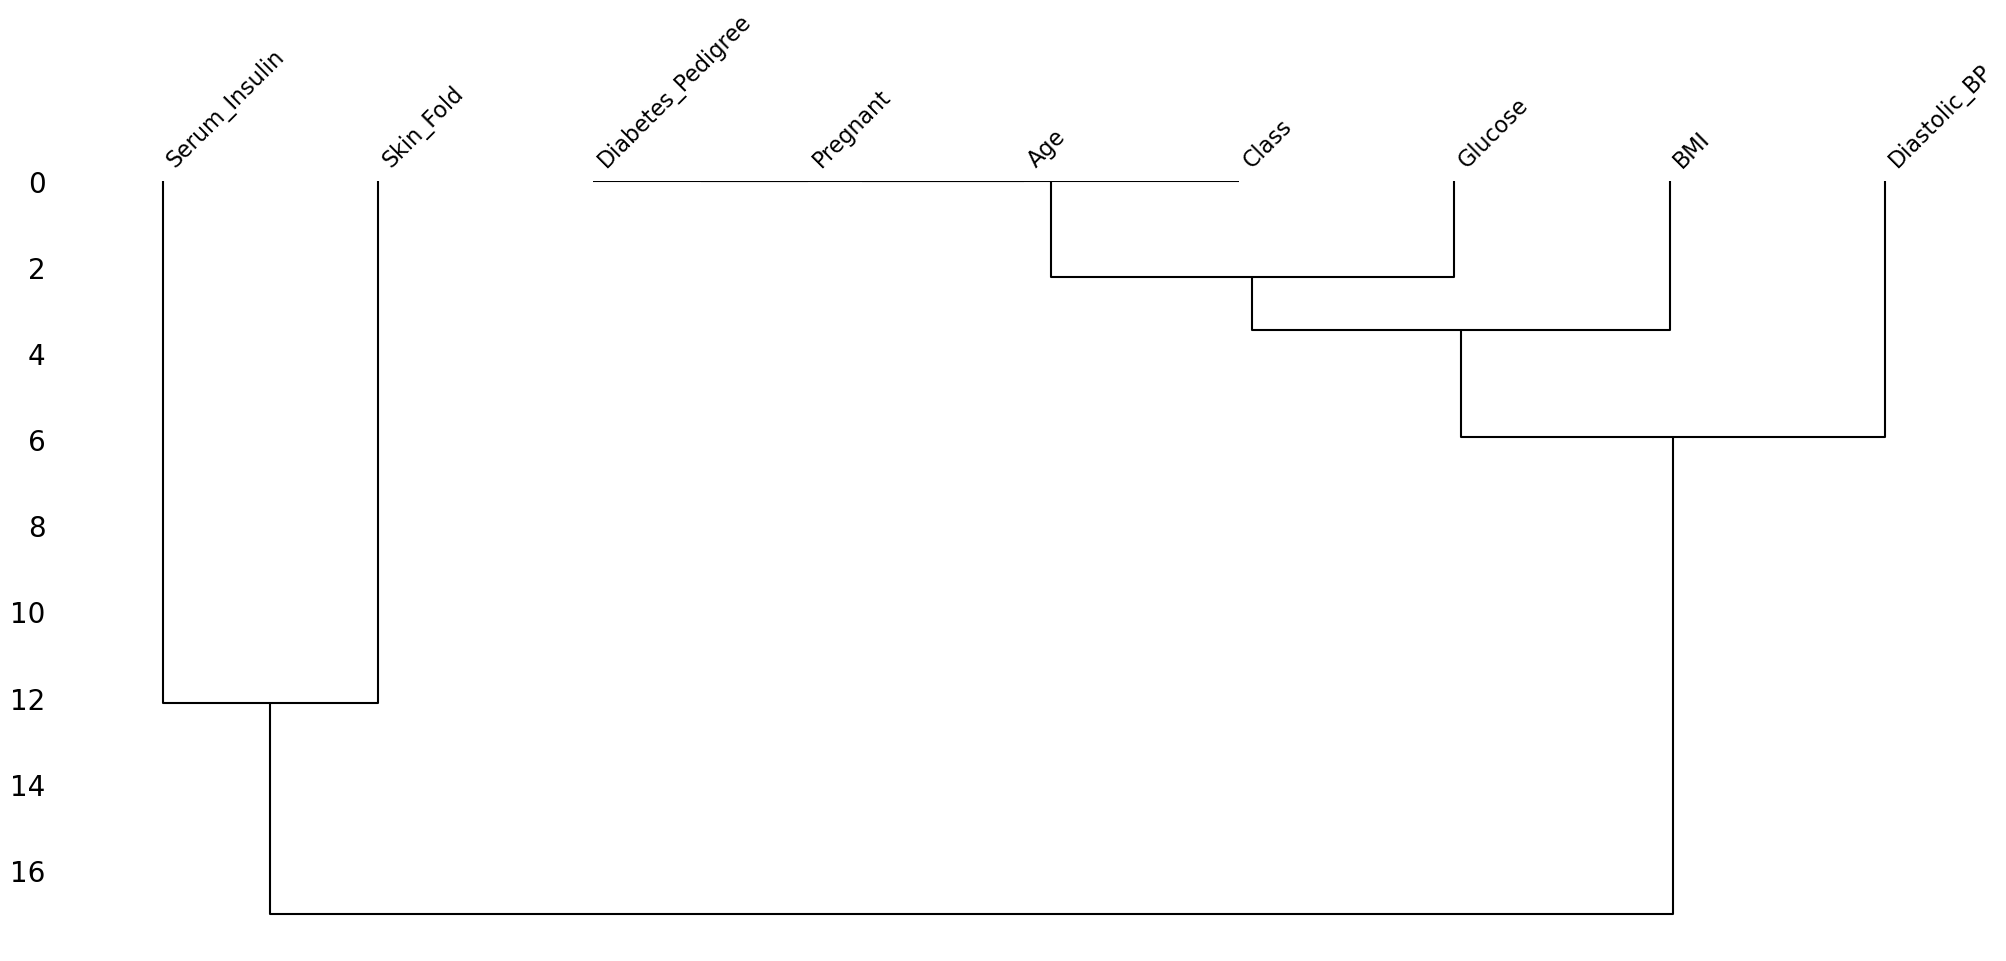

In [22]:
msno.dendrogram(df)
plt.show()

The strongest correlation is observed between `Serum_Insulin` and `Skin_Fold`, suggesting that these two features share a significant amount of information and can potentially be used to impute one another using regression or multivariate techniques. Other correlations, such as between `BMI` and `Diastolic_BP`, are moderate, while most other pairwise relationships are weak. The dendrogram supports this finding, clustering `Serum_Insulin` and `Skin_Fold closely` together, indicating their similarity in data structure. 

#### MCAR, MAR and MNAR

In [25]:
df_missing = df.copy()

In [26]:
columns = ['Pregnant',
 'Glucose',
 'Diastolic_BP',
 'Skin_Fold',
 'Serum_Insulin',
 'BMI',
 'Diabetes_Pedigree',
 'Age']

missing_columns = ['Glucose',
 'Diastolic_BP',
 'Skin_Fold',
 'Serum_Insulin',
 'BMI']

In [27]:
def ks_test_matrix(df, missing_columns, test_columns):
    results = pd.DataFrame(index = test_columns, columns = missing_columns)

    for missing_col in missing_columns:
        df['missing_values'] = df[missing_col].isnull().astype(int)

        for col in test_columns:
            if col == missing_col:
                results.loc[col, missing_col] = None
                continue

            group1 = df[df['missing_values'] == 1][col].dropna()
            group2 = df[df['missing_values'] == 0][col].dropna()

            if len(group1) > 1 and len(group2) > 1:
                stat = ks_2samp(group1, group2)
                results.loc[col, missing_col] = stat.pvalue
            else:
                results.loc[col, missing_col] = None

    return results.astype(float)

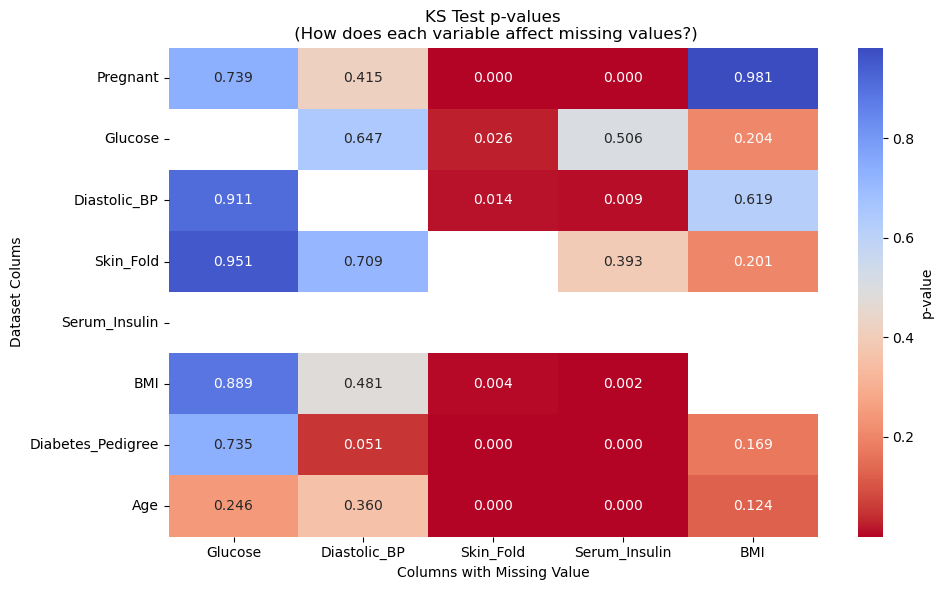

In [28]:
ks_pvalues = ks_test_matrix(df.copy(), missing_columns, columns)

plt.figure(figsize=(10, 6))
sns.heatmap(ks_pvalues, annot=True, fmt=".3f", cmap="coolwarm_r", cbar_kws={'label': 'p-value'})
plt.title("KS Test p-values\n (How does each variable affect missing values?)")
plt.xlabel("Columns with Missing Value")
plt.ylabel("Dataset Colums")
plt.tight_layout()
plt.show()

The KS test p-value heatmap provides crucial insights for classifying the missing data mechanisms (MCAR, MAR, MNAR) across variables. Variables such as `Skin_Fold` and `Serum_Insulin` display very low p-values (< 0.05) across multiple predictors, particularly with `Pregnant`, `Diastolic_BP`, `BMI`, and `Diabetes_Pedigree`, suggesting that their missingness is not completely at random. This pattern supports the **Missing At Random (MAR)** hypothesis for these variables, the probability of missingness is related to other observed variables. `BMI` also shows **MAR** behavior, especially in relation to `Pregnant` and `Serum_Insulin`.

In contrast, `Glucose` exhibits relatively high p-values for most pairwise tests, suggesting that its missingness is largely unrelated to the other observed variables. This aligns more closely with the **Missing Completely At Random (MCAR)** assumption, meaning that excluding or imputing these values would introduce minimal bias. `Diastolic_BP` shows mixed behavior, with significant p-values with `Skin_Fold` and `Serum_Insulin`, possibly indicating **MAR** or even **MNAR (Missing Not At Random)** if the missingness depends on unobserved values or the variable itself.

Overall, these findings highlight the necessity of employing variable-specific imputation strategies: mean/mode imputation may suffice for near-**MCAR** features like `Glucose`, while **MAR**-type variables (`Serum_Insulin`, `Skin_Fold`, `BMI`) should be addressed using multivariate methods such as MICE or model-based imputation to mitigate bias.

## Techniques

In [31]:
# Class balance

df["Class"].value_counts() / len(df) * 100

Class
0    65.104167
1    34.895833
Name: count, dtype: float64

In [32]:
def classification_models(X, y):
   
    # Stratified Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42, test_size = 0.25)

    # Models
    models = {"Dummy Stratified": DummyClassifier(strategy = "stratified", random_state = 42),
              "Random Forest": RandomForestClassifier(class_weight = "balanced", random_state = 42),
              "Logistic Regression": LogisticRegression(class_weight = "balanced", max_iter=1000, random_state = 42),
              "XGBoost": XGBClassifier(scale_pos_weight = (y == 0).sum() / (y == 1).sum(), eval_metric = "logloss", random_state = 42)}

    results = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Prob
        try:
            y_prob = model.predict_proba(X_test)[:, 1]
            auc = round(roc_auc_score(y_test, y_prob), 3)
        except:
            auc = None
        
        f1 = round(f1_score(y_test, y_pred), 3)

        results[name] = {
            "F1-Score": f1,
            "ROC AUC": auc
        }

    return results

In [33]:
# Distributions comparsion

def plot_comparison_histograms(before_df, after_df):
    

    for column in before_df.columns:
        
        if before_df[column].isna().sum() > 0:
            
            plt.figure(figsize=(12, 4))
    

            # Original Dataset Histogram
            sns.histplot(before_df[column].dropna(), kde = True, bins = 30, color = "salmon", label = "Before", stat = "density", alpha = 0.5)
     
            # Histogram with processed data
            sns.histplot(after_df[column].dropna(), kde = True, bins = 30, color = "steelblue", label = "After", stat = "density", alpha = 0.5)
    
            plt.title(f'Distribution de {column}: Before vs After')
            plt.xlabel(column)
            plt.ylabel('Density')
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

### Drop Values

In [35]:
df_1 = df.copy()

In [36]:
df_1.dropna(inplace = True)

In [37]:
print(f"We lost {(1 - df_1.shape[0]/df.shape[0]) * 100:.2f} % of the data")

We lost 48.96 % of the data


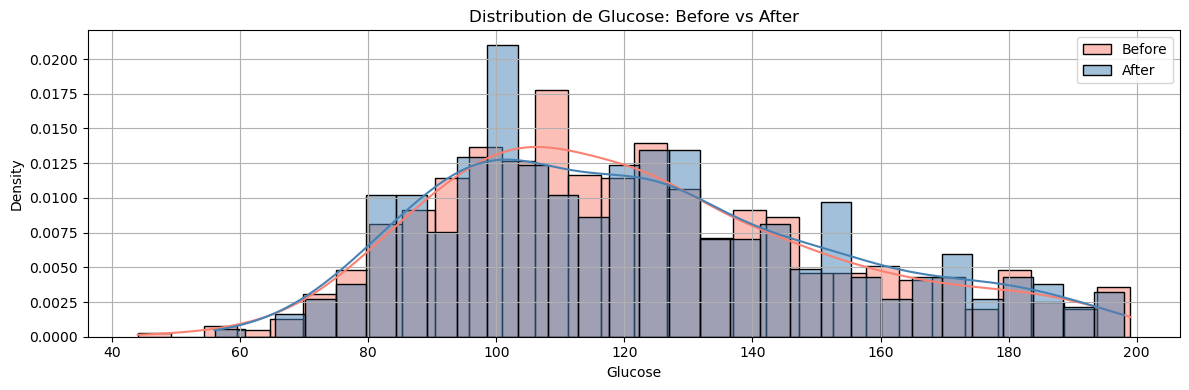

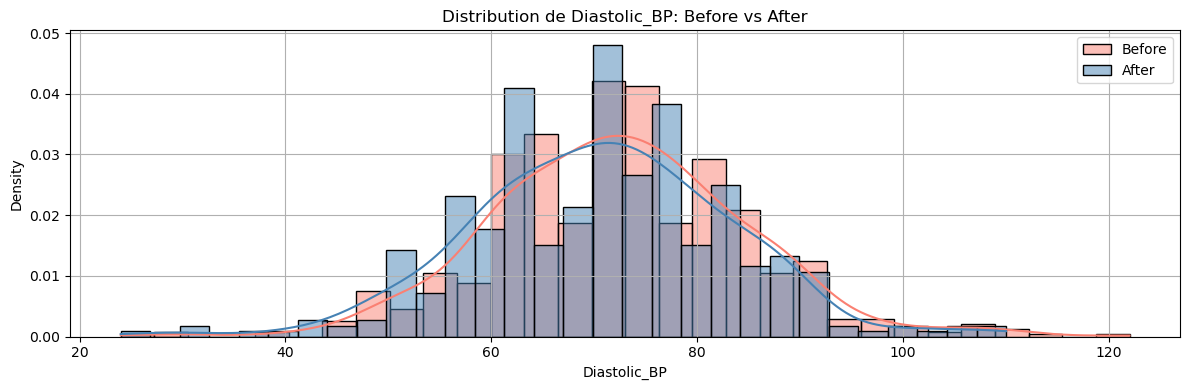

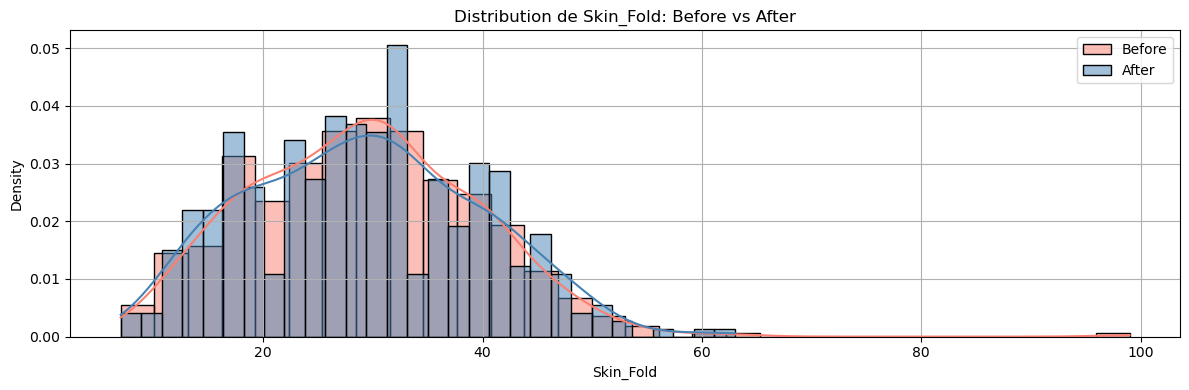

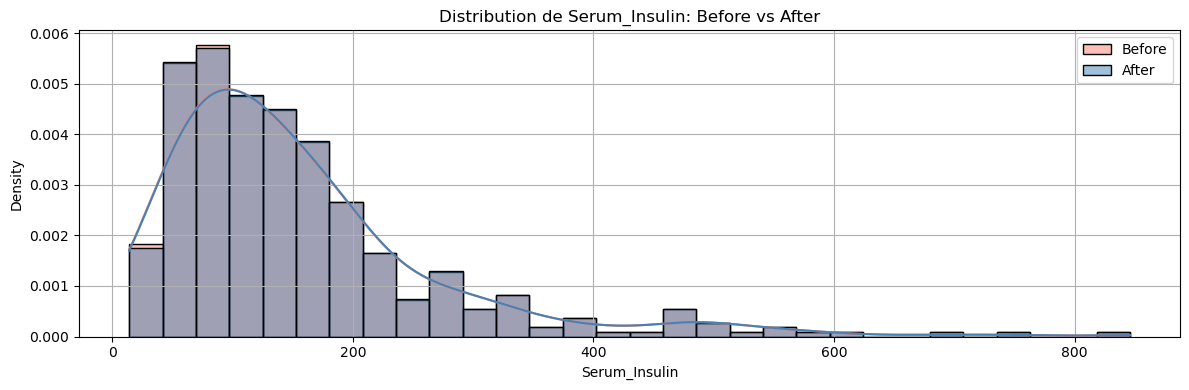

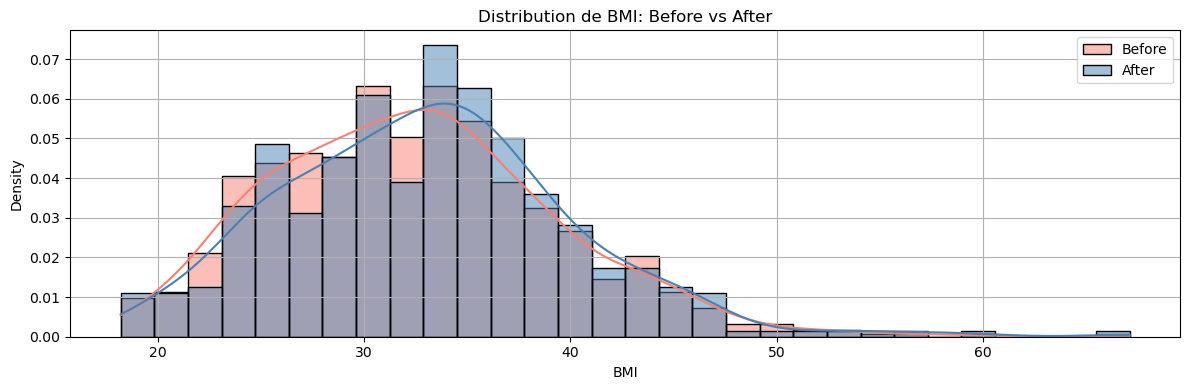

In [38]:
plot_comparison_histograms(df, df_1)

In [39]:
X_1 = df_1.drop(columns = "Class")
y_1 = df_1["Class"]
drop_test = classification_models(X_1, y_1)
drop_test

{'Dummy Stratified': {'F1-Score': 0.381, 'ROC AUC': 0.544},
 'Random Forest': {'F1-Score': 0.613, 'ROC AUC': 0.813},
 'Logistic Regression': {'F1-Score': 0.667, 'ROC AUC': 0.847},
 'XGBoost': {'F1-Score': 0.696, 'ROC AUC': 0.793}}

The results after dropping all rows with missing values show a significant decrease in dataset size, yet relatively strong model performance—particularly for Logistic Regression and XGBoost. While the baseline Dummy classifier performs poorly (F1 = 0.381, ROC AUC = 0.544), the trained models achieve substantially higher scores. XGBoost yields the best F1-Score (0.696), indicating strong predictive capability, although its ROC AUC (0.793) is slightly lower than that of Logistic Regression (0.847), which suggests better overall ranking performance for the latter.

### Mean

In [42]:
df_2 = df.copy()

In [43]:
df_2 = df_2.fillna(df_2.mean())

In [44]:
df_2.describe()

,Pregnant,Glucose,Diastolic_BP,Skin_Fold,Serum_Insulin,BMI,Diabetes_Pedigree,Age,Class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.435949,12.096346,8.790942,85.021108,6.875151,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.202592,29.153420,155.548223,32.400000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,155.548223,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


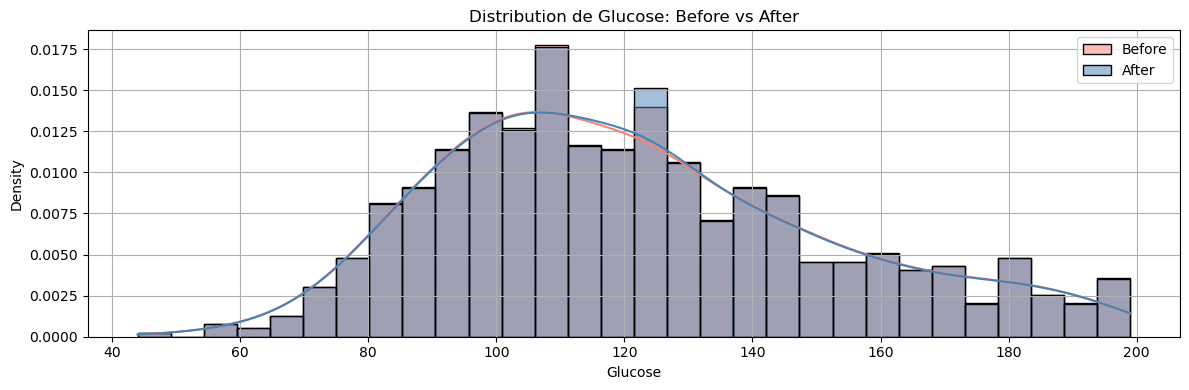

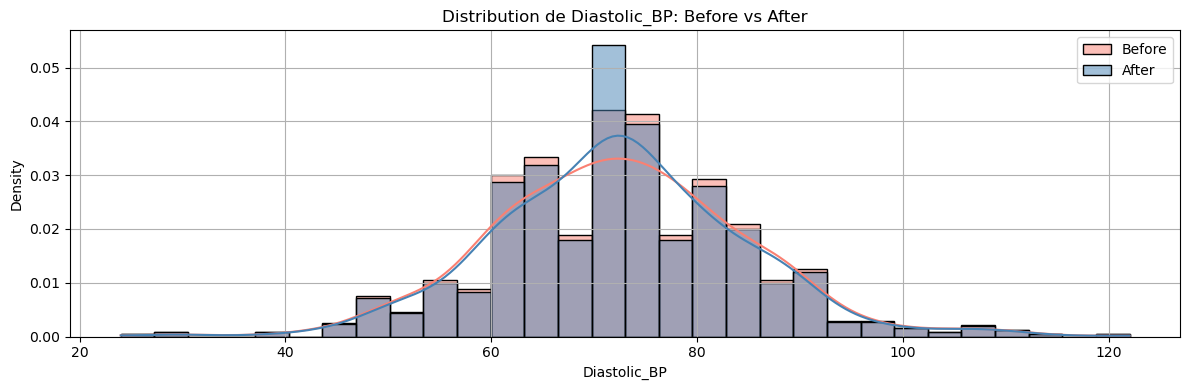

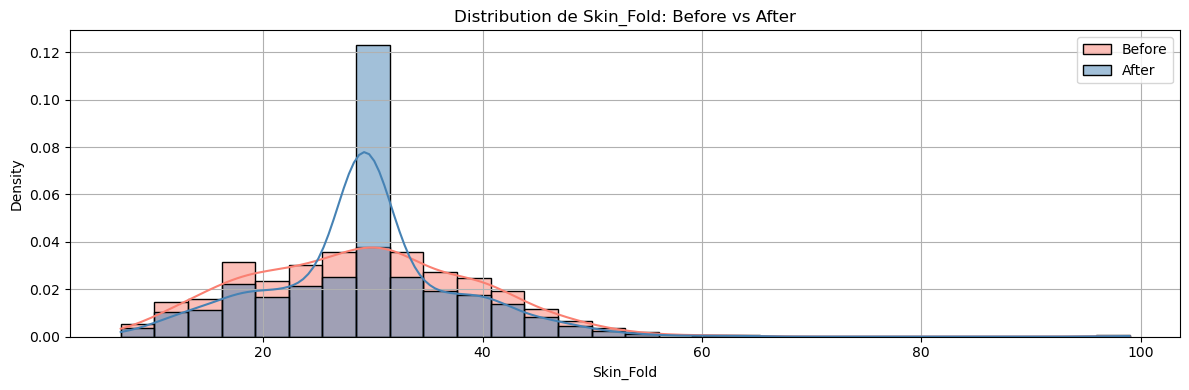

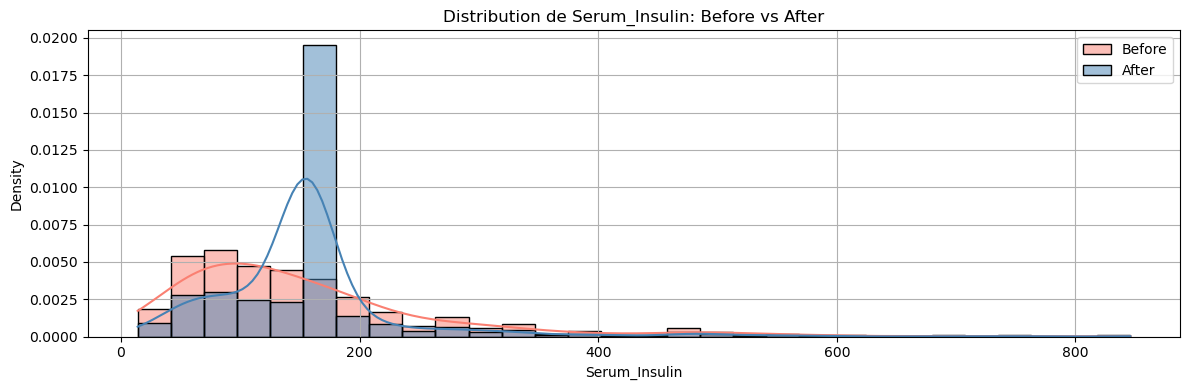

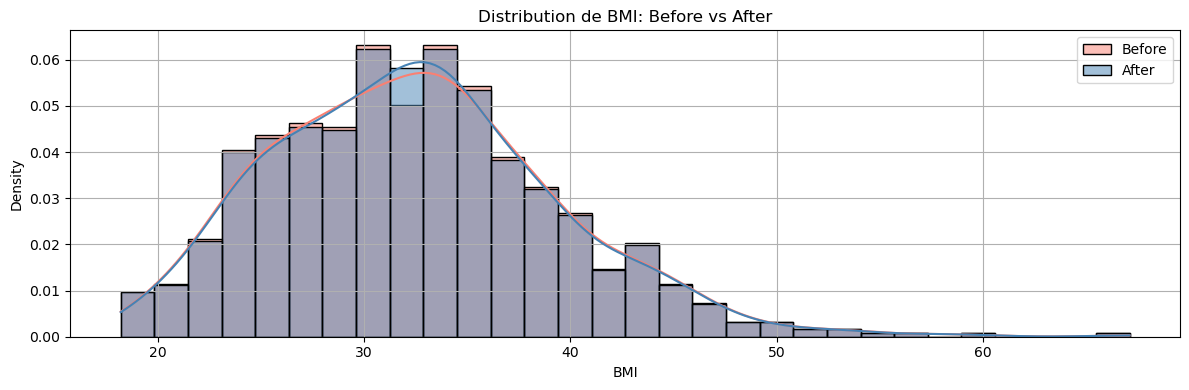

In [45]:
plot_comparison_histograms(df, df_2)

In [46]:
X_2 = df_2.drop(columns = "Class")
y_2 = df_2["Class"]
mean_test = classification_models(X_2, y_2)
mean_test

{'Dummy Stratified': {'F1-Score': 0.344, 'ROC AUC': 0.508},
 'Random Forest': {'F1-Score': 0.607, 'ROC AUC': 0.816},
 'Logistic Regression': {'F1-Score': 0.652, 'ROC AUC': 0.822},
 'XGBoost': {'F1-Score': 0.632, 'ROC AUC': 0.796}}

When missing values are replaced using the mean, model performance remains relatively strong, though there is a slight decline in metrics compared to the case where missing rows were dropped. Notably, Logistic Regression and Random Forest maintain robust ROC AUC scores (0.822 and 0.816, respectively), indicating effective discrimination capability. However, F1-scores drop slightly for all models, especially for XGBoost (from 0.696 to 0.632), suggesting that mean imputation may weaken precision or recall, likely due to the distortion of variable distributions—particularly in skewed features like Serum_Insulin.

The degradation in Dummy classifier performance (F1 = 0.344, ROC AUC = 0.508) highlights that mean imputation introduces enough noise to reduce even baseline stability. These results suggest that although mean imputation is simple and allows for full data retention, it may not be optimal for variables with MAR/MNAR missingness or non-normal distributions.

### Median

In [49]:
df_3 = df.copy()

In [50]:
df_3 = df_3.fillna(df_3.median())

In [51]:
df_3.describe()

,Pregnant,Glucose,Diastolic_BP,Skin_Fold,Serum_Insulin,BMI,Diabetes_Pedigree,Age,Class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,29.108073,140.671875,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,8.791221,86.383060,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


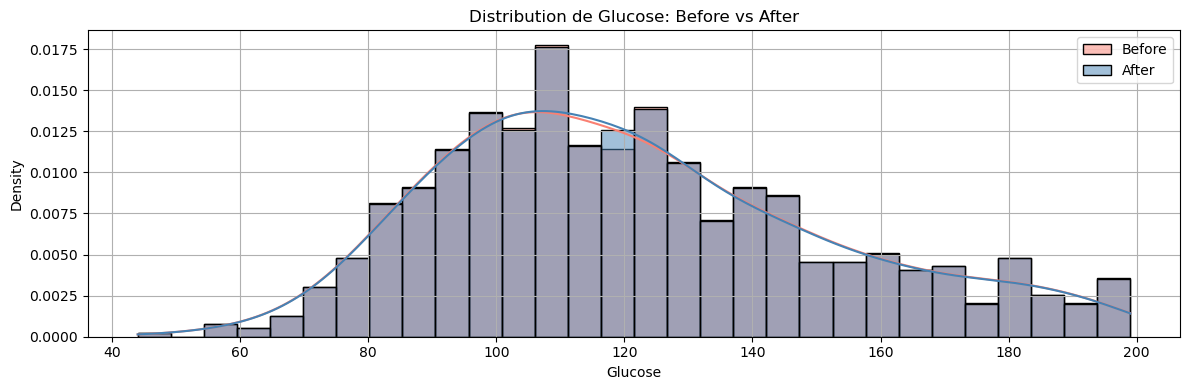

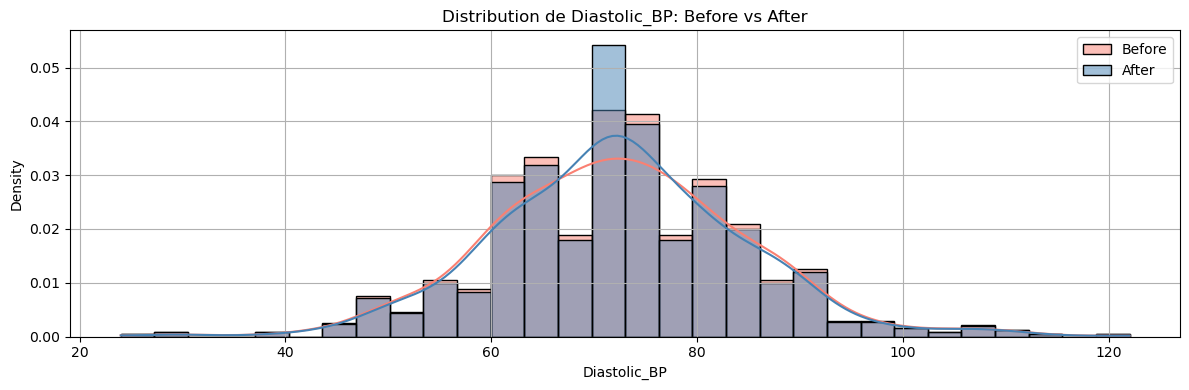

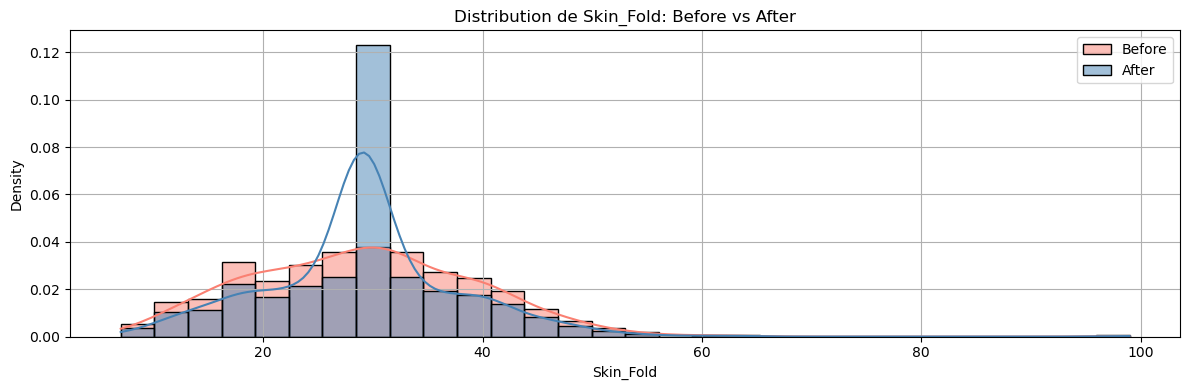

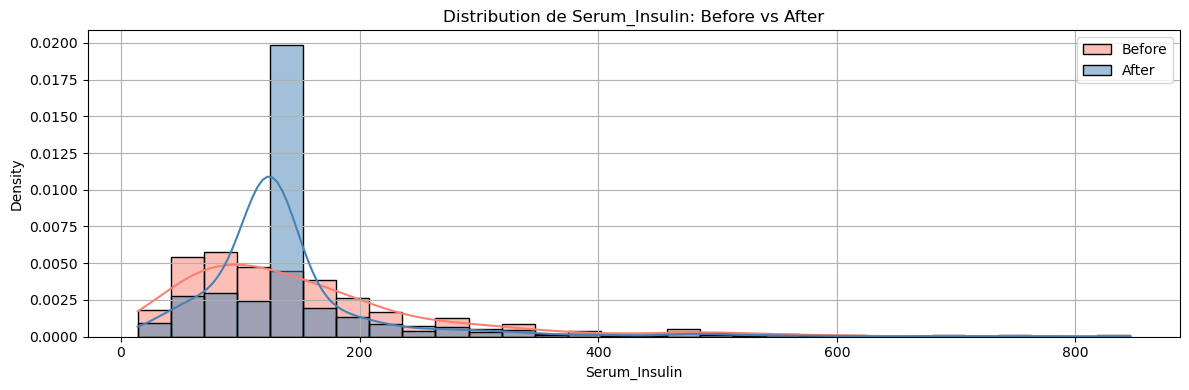

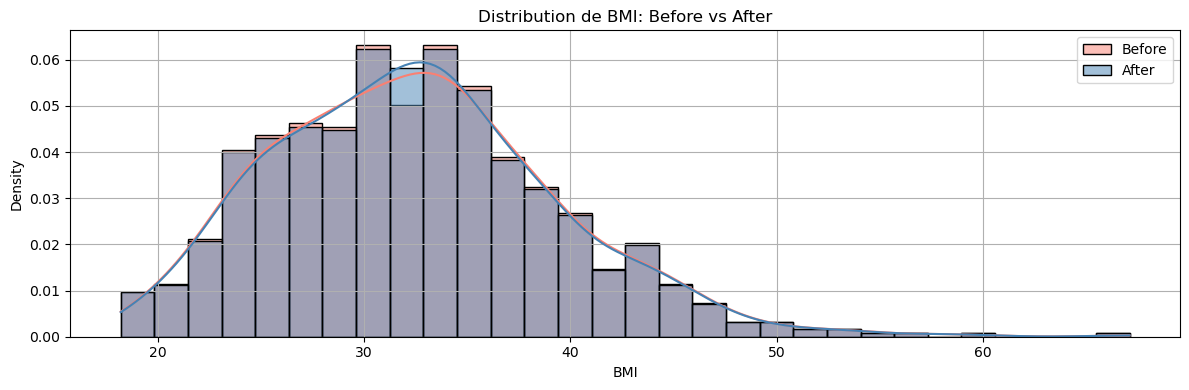

In [52]:
plot_comparison_histograms(df, df_3)

In [53]:
X_3 = df_3.drop(columns = "Class")
y_3 = df_3["Class"]
median_test = classification_models(X_3, y_3)
median_test

{'Dummy Stratified': {'F1-Score': 0.344, 'ROC AUC': 0.508},
 'Random Forest': {'F1-Score': 0.576, 'ROC AUC': 0.819},
 'Logistic Regression': {'F1-Score': 0.652, 'ROC AUC': 0.822},
 'XGBoost': {'F1-Score': 0.612, 'ROC AUC': 0.791}}

With median imputation, the models maintain similar overall performance to mean imputation, though slight shifts in results are observed. Logistic Regression again delivers the highest ROC AUC (0.822) and a solid F1-score (0.652), indicating that it remains robust to central-tendency imputations. Random Forest and XGBoost both see marginal drops in F1-scores compared to the mean imputation scenario, suggesting that median values may provide less predictive signal for some features, possibly due to reduced variance in the imputed data.

Interestingly, the Dummy classifier’s performance remains unchanged (F1 = 0.344, ROC AUC = 0.508), showing that the imputation method has limited effect on non-informative models. Overall, median imputation performs comparably to mean imputation and may be slightly more appropriate for skewed variables (e.g., Serum_Insulin), but still fails to leverage potential inter-feature dependencies. 

### Delete Columns 

Columns with more than 20% of missing values will be remved: `Skin_Fold`, `Serum_Insulin`

In [57]:
df_4 = df[['Pregnant', 'Glucose', 'Diastolic_BP', 'BMI', 'Diabetes_Pedigree', 'Age', 'Class']].copy()
df_4.head()

,Pregnant,Glucose,Diastolic_BP,BMI,Diabetes_Pedigree,Age,Class
0,6,148.0,72.0,33.6,0.627,50,1
1,1,85.0,66.0,26.6,0.351,31,0
2,8,183.0,64.0,23.3,0.672,32,1
3,1,89.0,66.0,28.1,0.167,21,0
4,0,137.0,40.0,43.1,2.288,33,1


####  Delete Columns + Drop

In [59]:
df_4_1 = df_4.copy()

In [60]:
df_4_1.dropna(inplace = True)

In [61]:
print(f"We lost {(1 - df_4_1.shape[0]/df_4.shape[0]) * 100:.2f} % of the data")

We lost 5.73 % of the data


In [62]:
X_4_1 = df_4_1.drop(columns = "Class")
y_4_1 = df_4_1["Class"]
column_drop_test = classification_models(X_4_1, y_4_1)
column_drop_test

{'Dummy Stratified': {'F1-Score': 0.305, 'ROC AUC': 0.485},
 'Random Forest': {'F1-Score': 0.605, 'ROC AUC': 0.761},
 'Logistic Regression': {'F1-Score': 0.613, 'ROC AUC': 0.763},
 'XGBoost': {'F1-Score': 0.537, 'ROC AUC': 0.734}}

In this scenario, where the two variables with the highest missingness (Skin_Fold and Serum_Insulin) are dropped and the remaining missing values are removed row-wise—resulting in only a 5.73% data loss—the performance of most models slightly decreases compared to previous approaches. While Random Forest and Logistic Regression still show decent F1-scores (0.605 and 0.613, respectively), their ROC AUC values (0.761 and 0.763) are noticeably lower than in prior strategies that retained all features via imputation or full-row removal.

The drop in performance suggests that Skin_Fold and Serum_Insulin, despite their high missingness, contain relevant predictive information. Their removal appears to reduce model discriminative power, particularly for XGBoost, whose F1-score drops significantly to 0.537. Additionally, the Dummy classifier's results further confirm that this strategy weakens the signal-to-noise ratio.

#### Delete Columns + Mean

In [65]:
df_4_2 = df_4.copy()
df_4_2 = df_4_2.fillna(df_4_2.mean())

X_4_2 = df_4_2.drop(columns = "Class")
y_4_2 = df_4_2["Class"]
column_mean_test = classification_models(X_4_2, y_4_2)
column_mean_test

{'Dummy Stratified': {'F1-Score': 0.344, 'ROC AUC': 0.508},
 'Random Forest': {'F1-Score': 0.592, 'ROC AUC': 0.814},
 'Logistic Regression': {'F1-Score': 0.657, 'ROC AUC': 0.824},
 'XGBoost': {'F1-Score': 0.652, 'ROC AUC': 0.797}}

After dropping the two most incomplete variables (Skin_Fold and Serum_Insulin) and applying mean imputation to the remaining missing values, model performance improves noticeably compared to the previous approach that also dropped rows. Logistic Regression achieves the highest ROC AUC (0.824) and a strong F1-score (0.657), indicating that the imputation strategy helps preserve valuable patterns in the data. Similarly, Random Forest and XGBoost show improved results (F1 = 0.592 and 0.652, respectively), particularly in terms of ROC AUC, which suggests good ranking ability.

Compared to the strategy of dropping all missing rows, this approach offers a better balance between simplicity and information retention. Although some potentially informative features were removed, mean imputation on the remaining variables appears sufficient to maintain model effectiveness, particularly for classifiers like Logistic Regression that handle linear relationships well. This outcome suggests that even basic imputation can outperform row deletion when the overall loss of information is minimized and the remaining variables are still predictive.

#### Delete Columns + Median

In [68]:
df_4_3 = df_4.copy()
df_4_3 = df_4_3.fillna(df_4_3.median())

X_4_3 = df_4_3.drop(columns = "Class")
y_4_3 = df_4_3["Class"]
column_median_test = classification_models(X_4_3, y_4_3)
column_median_test

{'Dummy Stratified': {'F1-Score': 0.344, 'ROC AUC': 0.508},
 'Random Forest': {'F1-Score': 0.614, 'ROC AUC': 0.82},
 'Logistic Regression': {'F1-Score': 0.657, 'ROC AUC': 0.824},
 'XGBoost': {'F1-Score': 0.662, 'ROC AUC': 0.799}}

In this configuration—where Skin_Fold and Serum_Insulin were removed and the remaining missing values imputed using the median—model performance is among the best observed so far. Both Logistic Regression and XGBoost achieve strong F1-scores (0.657 and 0.662, respectively) with high ROC AUC values (0.824 and 0.799), suggesting that this combination of feature selection and imputation preserves critical information for classification. Random Forest also performs well, particularly in terms of ROC AUC (0.820), indicating stable discriminative ability.

Compared to mean imputation, median imputation provides slight performance gains—especially for XGBoost—likely due to its robustness to outliers and the skewed distributions identified earlier in variables like BMI and Glucose. These results highlight the advantage of using median imputation in datasets where some variables deviate significantly from normality.

Overall, this strategy offers a strong compromise: by discarding the most incomplete features and applying a robust imputation method to the rest, it maintains a high level of predictive performance without introducing significant complexity.

### KNN Imputer

In [71]:
df_5 = df.copy()

In [72]:
block_1 = ['Glucose', 'Diastolic_BP', 'BMI']
aux_block_1 = ['Pregnant', 'Age', 'Diabetes_Pedigree']

block_2 = ['Skin_Fold', 'Serum_Insulin']
aux_block_2 = ['Glucose', 'Diastolic_BP', 'BMI']

In [73]:
# Block 1 Imputation
cols_1 = block_1 + aux_block_1
scaled_1 = StandardScaler().fit_transform(df_5[cols_1])
imputed_1 = KNNImputer(n_neighbors=5).fit_transform(scaled_1)
df_5[block_1] = pd.DataFrame(imputed_1[:, :len(block_1)], columns=block_1)

# Block 2 Imputation (together due to high dependency)
cols_2 = block_2 + aux_block_2
scaled_2 = StandardScaler().fit_transform(df_5[cols_2])
imputed_2 = KNNImputer(n_neighbors=5).fit_transform(scaled_2)
df_5[block_2] = pd.DataFrame(imputed_2[:, :len(block_2)], columns=block_2)

In [74]:
X_5 = df_5.drop(columns = "Class")
y_5 = df_5["Class"]
KNN_test = classification_models(X_5, y_5)
KNN_test

{'Dummy Stratified': {'F1-Score': 0.344, 'ROC AUC': 0.508},
 'Random Forest': {'F1-Score': 0.569, 'ROC AUC': 0.817},
 'Logistic Regression': {'F1-Score': 0.652, 'ROC AUC': 0.824},
 'XGBoost': {'F1-Score': 0.627, 'ROC AUC': 0.807}}

The results obtained using KNNImputer show that this method produces competitive model performance, particularly in terms of ROC AUC scores. Logistic Regression maintains a high ROC AUC of 0.824, consistent with previous imputation strategies, while XGBoost and Random Forest achieve solid values of 0.807 and 0.818, respectively. However, F1-scores for all models—especially Random Forest (0.569) and XGBoost (0.627)—are slightly lower compared to median imputation, suggesting a modest tradeoff between classification balance and ranking ability.

These results imply that while KNNImputer effectively captures local patterns in the data based on feature similarity, it may introduce some noise or over-smoothing, particularly for skewed or sparse variables. This can affect class balance (reflected in F1-score) but still preserve relative ordering (captured by ROC AUC). Given its ability to incorporate multivariate information, KNNImputer is a useful tool, but its effectiveness is sensitive to the structure of the data and the choice of neighbors.

### MICE

In [77]:
df_6 = df.copy()

In [78]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_6)

In [79]:
mice = IterativeImputer(estimator=BayesianRidge(), max_iter=20, random_state=42)
imputed_data = mice.fit_transform(scaled_data)

In [80]:
df_imputed = pd.DataFrame(scaler.inverse_transform(imputed_data), columns=df.columns.values)

In [81]:
for col in missing_columns:
    df_6[col] = df_imputed[col]

In [82]:
X_6 = df_6.drop(columns = "Class")
y_6 = df_6["Class"]
MICE_test = classification_models(X_6, y_6)
MICE_test

{'Dummy Stratified': {'F1-Score': 0.344, 'ROC AUC': 0.508},
 'Random Forest': {'F1-Score': 0.548, 'ROC AUC': 0.819},
 'Logistic Regression': {'F1-Score': 0.662, 'ROC AUC': 0.823},
 'XGBoost': {'F1-Score': 0.593, 'ROC AUC': 0.787}}

Using MICE (Multiple Imputation by Chained Equations) results in a slight improvement for Logistic Regression, which reaches its highest F1-score so far (0.662) and maintains a strong ROC AUC (0.823), confirming that this model benefits from the multivariate nature of MICE. However, Random Forest and especially XGBoost experience modest drops in F1-scores (0.548 and 0.593, respectively), even though their ROC AUC values remain fairly high (0.819 and 0.787). This suggests that while MICE captures complex dependencies well, it may introduce variance that affects models sensitive to overfitting or noise.

The Dummy classifier's unchanged performance confirms that the baseline remains unaffected by the imputation strategy. Overall, MICE proves effective at preserving global relationships in the dataset—especially useful under MAR assumptions—but may not uniformly enhance performance across all model types. 

## Analysis and Conclusion

In [85]:
strategies = {
    'Drop': drop_test,
    'Mean': mean_test,
    'Median': median_test,
    'Drop + Columns': column_drop_test,
    'Mean + Columns': column_mean_test,
    'Median + Columns': column_median_test,
    'KNN': KNN_test,
    'MICE': MICE_test
}

rows = []
for strategy_name, models_dict in strategies.items():
    for model_name, metrics in models_dict.items():
        rows.append({
            'Strategy': strategy_name,
            'Model': model_name,
            'F1-Score': metrics['F1-Score'],
            'ROC AUC': metrics['ROC AUC']
        })


df_metrics = pd.DataFrame(rows)

df_metrics

,Strategy,Model,F1-Score,ROC AUC
0,Drop,Dummy Stratified,0.381,0.544
1,Drop,Random Forest,0.613,0.813
2,Drop,Logistic Regression,0.667,0.847
3,Drop,XGBoost,0.696,0.793
4,Mean,Dummy Stratified,0.344,0.508
5,Mean,Random Forest,0.607,0.816
6,Mean,Logistic Regression,0.652,0.822
7,Mean,XGBoost,0.632,0.796
8,Median,Dummy Stratified,0.344,0.508
9,Median,Random Forest,0.576,0.819


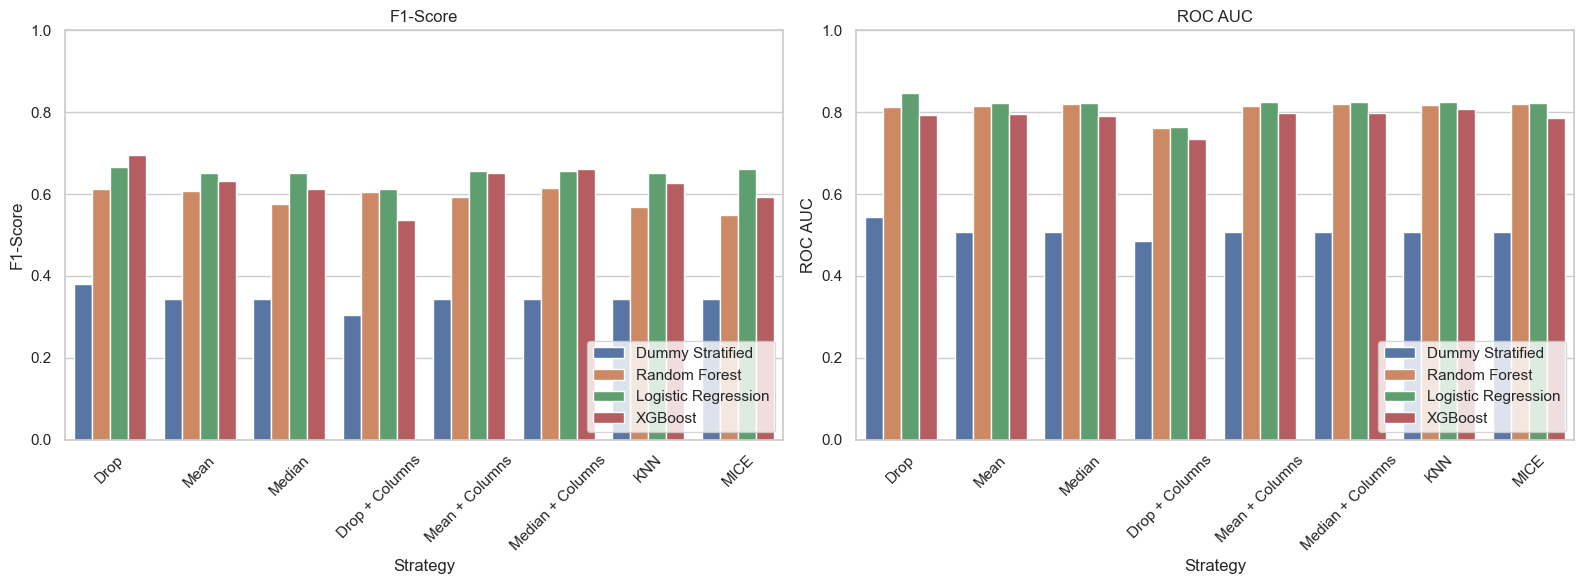

In [86]:
sns.set(style="whitegrid")

plt.figure(figsize=(16, 6))

# F1-Score
plt.subplot(1, 2, 1)
sns.barplot(data=df_metrics, x='Strategy', y='F1-Score', hue='Model')
plt.title('F1-Score')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.tight_layout()

# ROC AUC
plt.subplot(1, 2, 2)
sns.barplot(data=df_metrics, x='Strategy', y='ROC AUC', hue='Model')
plt.title('ROC AUC')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.tight_layout()


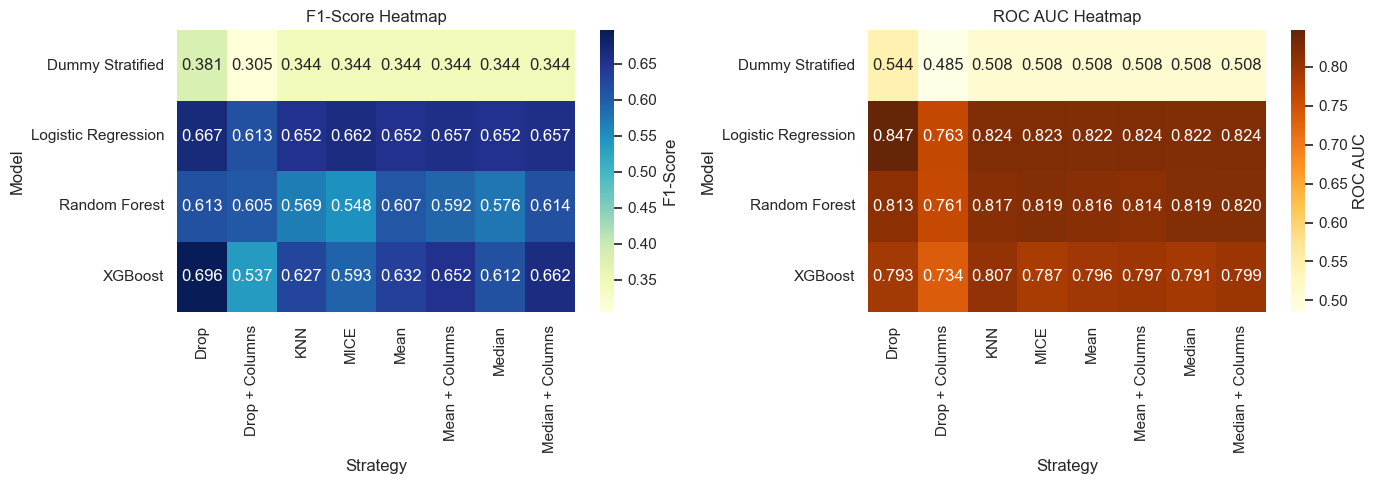

In [87]:
# Pivot Table
pivot_f1 = df_metrics.pivot(index='Model', columns='Strategy', values='F1-Score')
pivot_auc = df_metrics.pivot(index='Model', columns='Strategy', values='ROC AUC')


# Plot heatmaps
plt.figure(figsize=(14, 5))

# F1-Score Heatmap
plt.subplot(1, 2, 1)
sns.heatmap(
    pivot_f1,
    annot=True,
    fmt=".3f",
    cmap="YlGnBu",
    cbar_kws={'label': 'F1-Score'}
)
plt.title('F1-Score Heatmap')

# ROC AUC Heatmap
plt.subplot(1, 2, 2)
sns.heatmap(
    pivot_auc,
    annot=True,
    fmt=".3f",
    cmap="YlOrBr",
    cbar_kws={'label': 'ROC AUC'}
)
plt.title('ROC AUC Heatmap')

plt.tight_layout()
plt.show()

**Best Overall Performance:**

The combination of median imputation with removal of the most incomplete features (Skin_Fold and Serum_Insulin) achieves the best balance across all models. Logistic Regression and XGBoost both reach top F1-scores (0.657 and 0.662, respectively), while Logistic Regression consistently yields the highest ROC AUC (0.824) across all strategies, showing its robustness to different imputation methods.

**Simple Imputation vs. Advanced Methods:**

Surprisingly, simple imputation methods (mean/median)—especially when combined with column removal—perform as well as or better than more sophisticated techniques like KNN and MICE. While MICE slightly boosts Logistic Regression's F1-score (0.662), it underperforms for Random Forest and XGBoost. KNN achieves stable results, but not enough to surpass median imputation in terms of F1-score.

**Dropping Data is Suboptimal:**

Both full-row deletion and column+row deletion result in the worst performance across all models, especially for XGBoost and the Dummy classifier. This confirms that removing missing data can lead to information loss and model degradation, particularly when the missingness is not MCAR (as earlier tests suggested MAR or MNAR patterns).

**Model Sensitivity:**

- Logistic Regression is the most stable across all strategies, benefiting the most from advanced imputations like MICE and KNN, but also performing well with median imputation.
- XGBoost performs best with median imputation and shows notable sensitivity to data deletion.
- Random Forest shows moderate fluctuations but remains competitive with median and mean strategies.

For this dataset, which exhibits a mix of MAR and MNAR missingness patterns, the optimal strategy is to remove high-missingness columns and apply median imputation to the remaining data. This approach not only simplifies preprocessing but also maintains high model performance across F1 and ROC AUC metrics.

Advanced imputation methods like MICE and KNN can be useful, especially when preserving inter-variable dependencies is essential. However, for practical purposes—especially in scenarios prioritizing simplicity, efficiency, and interpretability—median imputation with selective column removal offers the best trade-off between performance and complexity.

As a recommendation, future work should explore more context-aware imputation methods that go beyond simple statistical substitution, such as deep learning-based imputers or domain-informed techniques that leverage clinical or structural relationships within the data. It is also important to recognize that each dataset will respond differently to missing data handling strategies, depending on its structure, the missingness mechanism, and the relationship between features. Therefore, no single technique will be universally optimal. Incorporating feature importance analysis may help determine which variables are most critical to preserve, and assessing the impact of imputation on model calibration and fairness is particularly relevant in sensitive domains like healthcare. Finally, validating the conclusions on external datasets would help reinforce the robustness and applicability of the recommended approaches.